In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pca import PCA

import scipy.io

In [2]:
def split_data(X,test_size=0.3,seed=1997):
    np.random.seed(seed)
    N = len(X)
    if 0<test_size<1:
        test_size = int(N*test_size)
        
    indices = np.arange(N)
    np.random.shuffle(indices)
    X = X[indices]
    
    test_set = X[:test_size]
    train_set = X[test_size:]
    return train_set,test_set

def root_mean_squared_error(y_true,y_pred):
    squared_error = (y_true - y_pred)**2
    mean_squared_error = np.mean(squared_error,axis=-1)
    root_mean_squared_error = np.sqrt(mean_squared_error)
    return np.mean(root_mean_squared_error),np.std(root_mean_squared_error)

## 2nd Question

In [3]:
X = np.array([
    [0,-1],
    [1,0],
    [2,1],
    [1,1],
    [-1,1],
    [-1,-1],
    [-1,-1]
])

print(f'X.shape = {X.shape}')

X.shape = (7, 2)


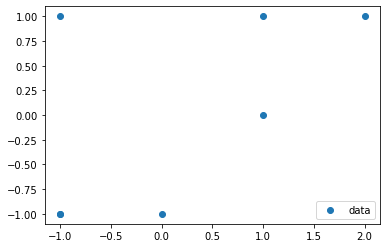

In [4]:
plt.scatter(X[:,0],X[:,1],label='data')
plt.legend()
#plt.savefig('data.png')

In [5]:
X_means = np.mean(X,axis=0,keepdims=True)
X_centered = X - X_means

In [6]:
V = np.array([
    [14/(np.sqrt(221)-5),-14/(np.sqrt(221)-5)],
    [1,1]
])

V = V/np.linalg.norm(V,axis=0)
V

array([[ 0.81741556, -0.81741556],
       [ 0.57604844,  0.57604844]])

In [7]:
W = V[:,:1]
W

array([[0.81741556],
       [0.57604844]])

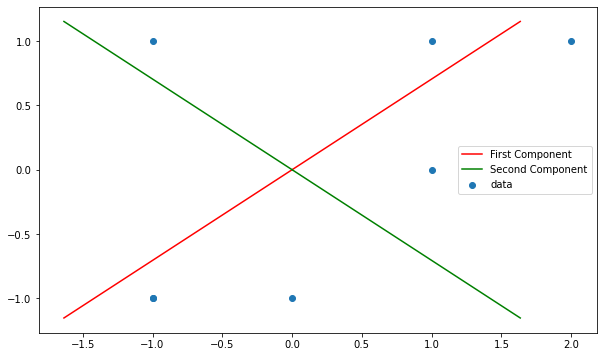

In [8]:
plt.figure(figsize=(10,6))

plt.scatter(X[:,0],X[:,1],label='data')

plt.plot([0,2*V[0,0]],[0,2*V[1,0]],'r-',label='First Component')
plt.plot([0,-2*V[0,0]],[0,-2*V[1,0]],'r-')

plt.plot([0,2*V[0,1]],[0,2*V[1,1]],'g-',label='Second Component')
plt.plot([0,-2*V[0,1]],[0,-2*V[1,1]],'g-')

plt.legend()
#plt.savefig('data_pc.png')

## Data Projection in 1D

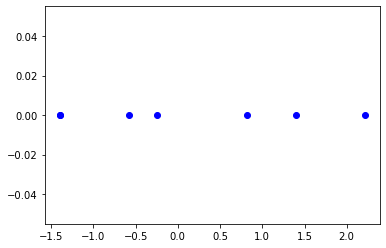

In [9]:
Z = X@W
plt.scatter(Z,np.zeros(len(Z)),c='b')
#plt.savefig('data_projection.png')

## Reconstructed X

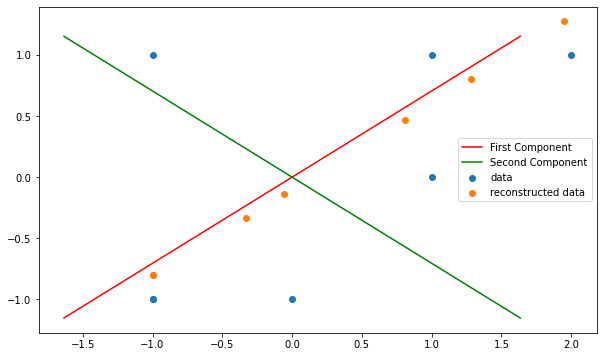

In [10]:
X_reconstruct = Z@W.T + X_means
plt.figure(figsize=(10,6))

plt.scatter(X[:,0],X[:,1],label='data')

plt.scatter(X_reconstruct[:,0],X_reconstruct[:,1],label='reconstructed data')

plt.plot([0,2*V[0,0]],[0,2*V[1,0]],'r-',label='First Component')
plt.plot([0,-2*V[0,0]],[0,-2*V[1,0]],'r-')

plt.plot([0,2*V[0,1]],[0,2*V[1,1]],'g-',label='Second Component')
plt.plot([0,-2*V[0,1]],[0,-2*V[1,1]],'g-')

plt.legend()
#plt.savefig('reconstructed.png')

In [11]:
m,s = root_mean_squared_error(X,X_reconstruct)
print(f'RMSE={m} -- std={s}')

RMSE=0.37869900235505227 -- std=0.30104517143866255


## Third Question

### Load dataset

In [12]:
faces = scipy.io.loadmat('faces.mat')['faces']
faces = np.swapaxes(faces,0,1)
print(f'DataSet.shape: {faces.shape}')

DataSet.shape: (400, 4096)


### Split dataset to train set and test set

In [13]:
train_set,test_set = split_data(faces,test_size=0.3)

print(f'train_set.shape: {train_set.shape}')
print(f'test_set.shape: {test_set.shape}')

train_set.shape: (280, 4096)
test_set.shape: (120, 4096)


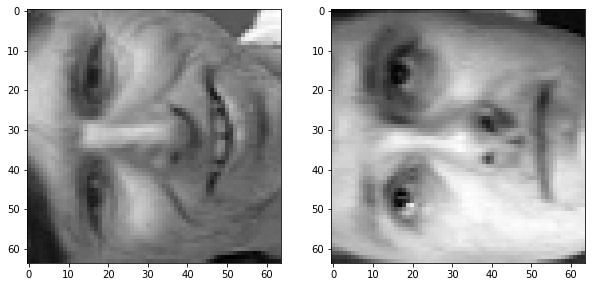

In [14]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(train_set[20].reshape(64,64),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_set[10].reshape(64,64),cmap='gray')
#plt.savefig('faces.png')

### Train PCA on train set

In [15]:
pca = PCA()
pca.fit(train_set)

#### Number of non zero principal component is 280, So we can compress data in 280 dim with almost zero information loss (Tiny amount of information loss caused by numerical errors)

In [16]:
print(f'Number of non zero principal component: {pca.n_non_zero_principal_component}')
print()
print('Using 280 PCs:')
m,s = root_mean_squared_error(train_set,pca.reconstruct(pca.transform(train_set,280)))
print(f'\tTrain RMSE: {m} -- std: {s}')
m,s = root_mean_squared_error(test_set,pca.reconstruct(pca.transform(test_set,280)))
print(f'\tTest RMSE: {m} -- std: {s}')

Number of non zero principal component: 280

Using 280 PCs:
	Train RMSE: 6.728648712132637e-14 -- std: 1.6181178849399864e-14
	Test RMSE: 10.336997818243393 -- std: 2.7060134369640703


In [17]:
print(f'Variance on first 20 principals:')
print(pca.principal_vars[:20])
print(f'Sum of Variance of first 20 principals: {np.sum(pca.principal_vars[:20])}')

Variance on first 20 principals:
[0.05125615 0.03690713 0.02877635 0.02274028 0.01912565 0.01775161
 0.01566072 0.01497029 0.01443459 0.01359927 0.01311196 0.01233171
 0.01177936 0.01110501 0.01080187 0.0099222  0.00973352 0.00910867
 0.0086908  0.00850809]
Sum of Variance of first 20 principals: 0.3403152231567398


In [18]:
dims = [280,192,138,98,68,45,28,16,8,3]

Z_train = [pca.transform(train_set,dim) for dim in dims]
Z_test = [pca.transform(test_set,dim) for dim in dims]

rmse_train = np.array([root_mean_squared_error(train_set,pca.reconstruct(Z)) for Z in Z_train])
rmse_test = np.array([root_mean_squared_error(test_set,pca.reconstruct(Z)) for Z in Z_test])

In [19]:
np.round(rmse_test[:,0],4)

array([10.337 , 11.133 , 11.9219, 12.8165, 13.8075, 15.075 , 16.7452,
       18.8807, 21.6531, 25.2744])

In [20]:
s = '10.337 , 11.133 , 11.9219, 12.8165, 13.8075, 15.075 , 16.7452,18.8807, 21.6531, 25.2744'
s.replace(',','&')

'10.337 & 11.133 & 11.9219& 12.8165& 13.8075& 15.075 & 16.7452&18.8807& 21.6531& 25.2744'

In [21]:
print(f'{rmse_train[:,0].round}')

<built-in method round of numpy.ndarray object at 0x7fe044324760>


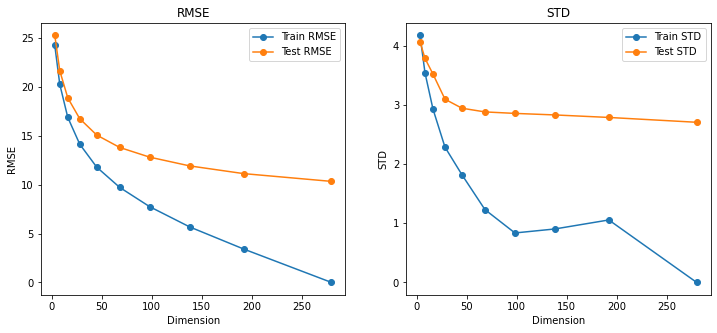

In [22]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('RMSE')
plt.xlabel('Dimension')
plt.ylabel('RMSE')
plt.plot(dims,rmse_train[:,0],marker='o',label='Train RMSE')
plt.plot(dims,rmse_test[:,0],marker='o',label='Test RMSE')
plt.legend()

plt.subplot(1,2,2)
plt.title('STD')
plt.xlabel('Dimension')
plt.ylabel('STD')
plt.plot(dims,rmse_train[:,1],marker='o',label='Train STD')
plt.plot(dims,rmse_test[:,1],marker='o',label='Test STD')
plt.legend()
#plt.savefig('rmse.png')

### Check on pictures

In [23]:
def f(pca,img,n_components):
    
    plt.figure(figsize=(100,10))
    plt.subplot(1,len(n_components)+1,1)
    plt.imshow(img.reshape(64,64),cmap='gray')
    plt.title('Orginal')
    for i,n_component in enumerate(n_components):
        Z = pca.transform(img,n_component)
        d = np.shape(Z)[-1]
        
        plt.subplot(1,len(n_components)+1,i+2)
        reconstruct = pca.reconstruct(Z)
        plt.imshow(reconstruct.reshape(64,64),cmap='gray')
        plt.title(f'dim={d} rmse={root_mean_squared_error(img,reconstruct)[0]:0.4f}')

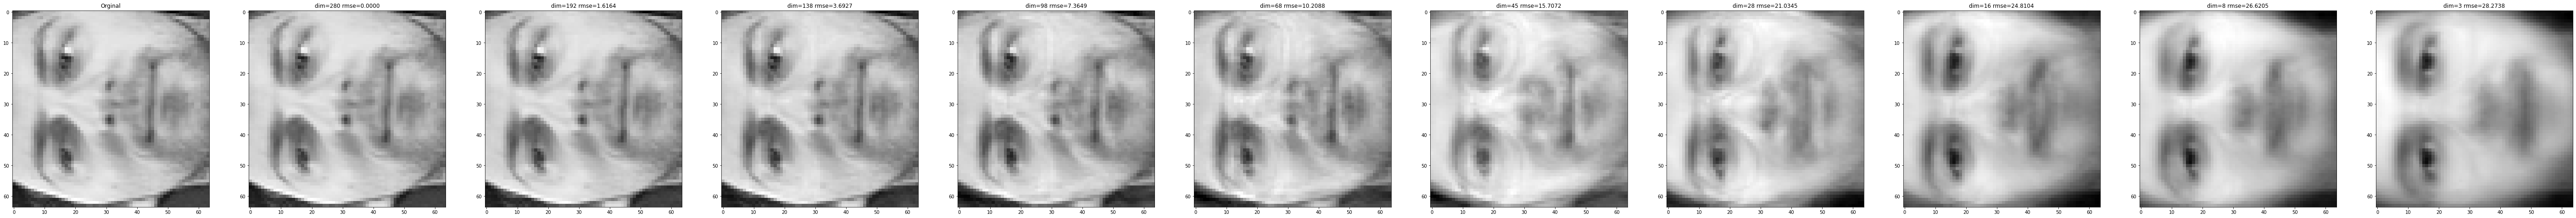

In [24]:
## Train set
f(pca,train_set[:1],dims)
#plt.savefig('train.jpg')

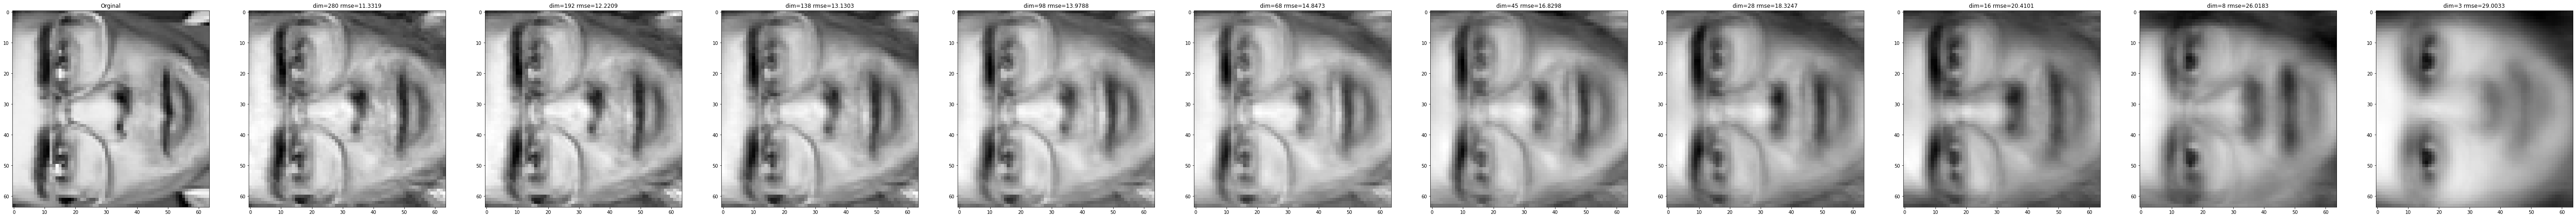

In [25]:
## Test set
f(pca,test_set[:1],dims)
#plt.savefig('test.jpg')

### Using 3000,280 PC to see how it works on test set

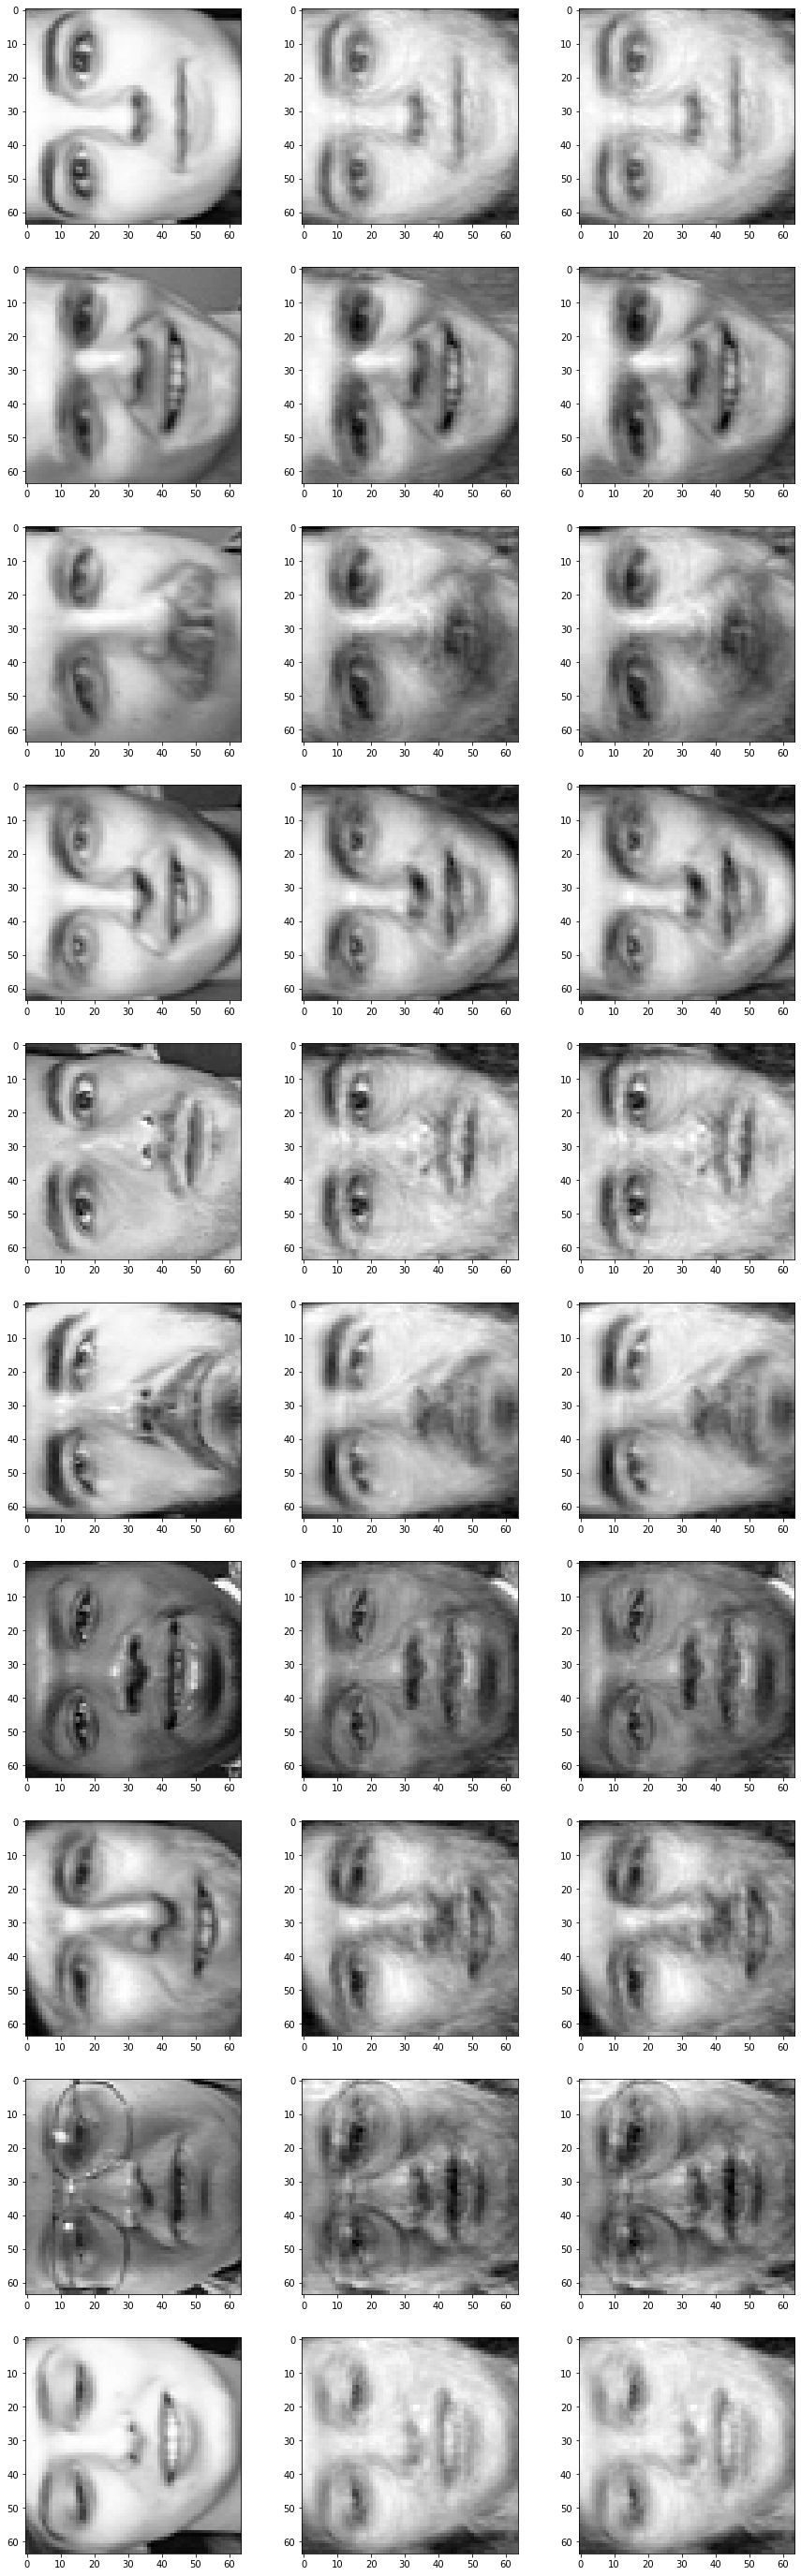

In [40]:
def g(n_components=3000):
    np.random.seed(1997)
    indices = np.random.randint(len(test_set),size=10)
    plt.figure(figsize=(15,50))
    images = test_set[indices]
    reconstructed = pca.reconstruct(pca.transform(images,n_components=n_components))
    reconstructed2 = pca.reconstruct(pca.transform(images,n_components=280))
    for i,(img,rimg,rimg2) in enumerate(zip(images,reconstructed,reconstructed2)):
        i +=1
        plt.subplot(10,3,3*i-2)
        plt.imshow(img.reshape(64,64),cmap='gray')
        plt.subplot(10,3,3*i-1)
        plt.imshow(rimg.reshape(64,64),cmap='gray')
        plt.subplot(10,3,3*i)
        plt.imshow(rimg2.reshape(64,64),cmap='gray')
        
g()
#plt.savefig('l.png')

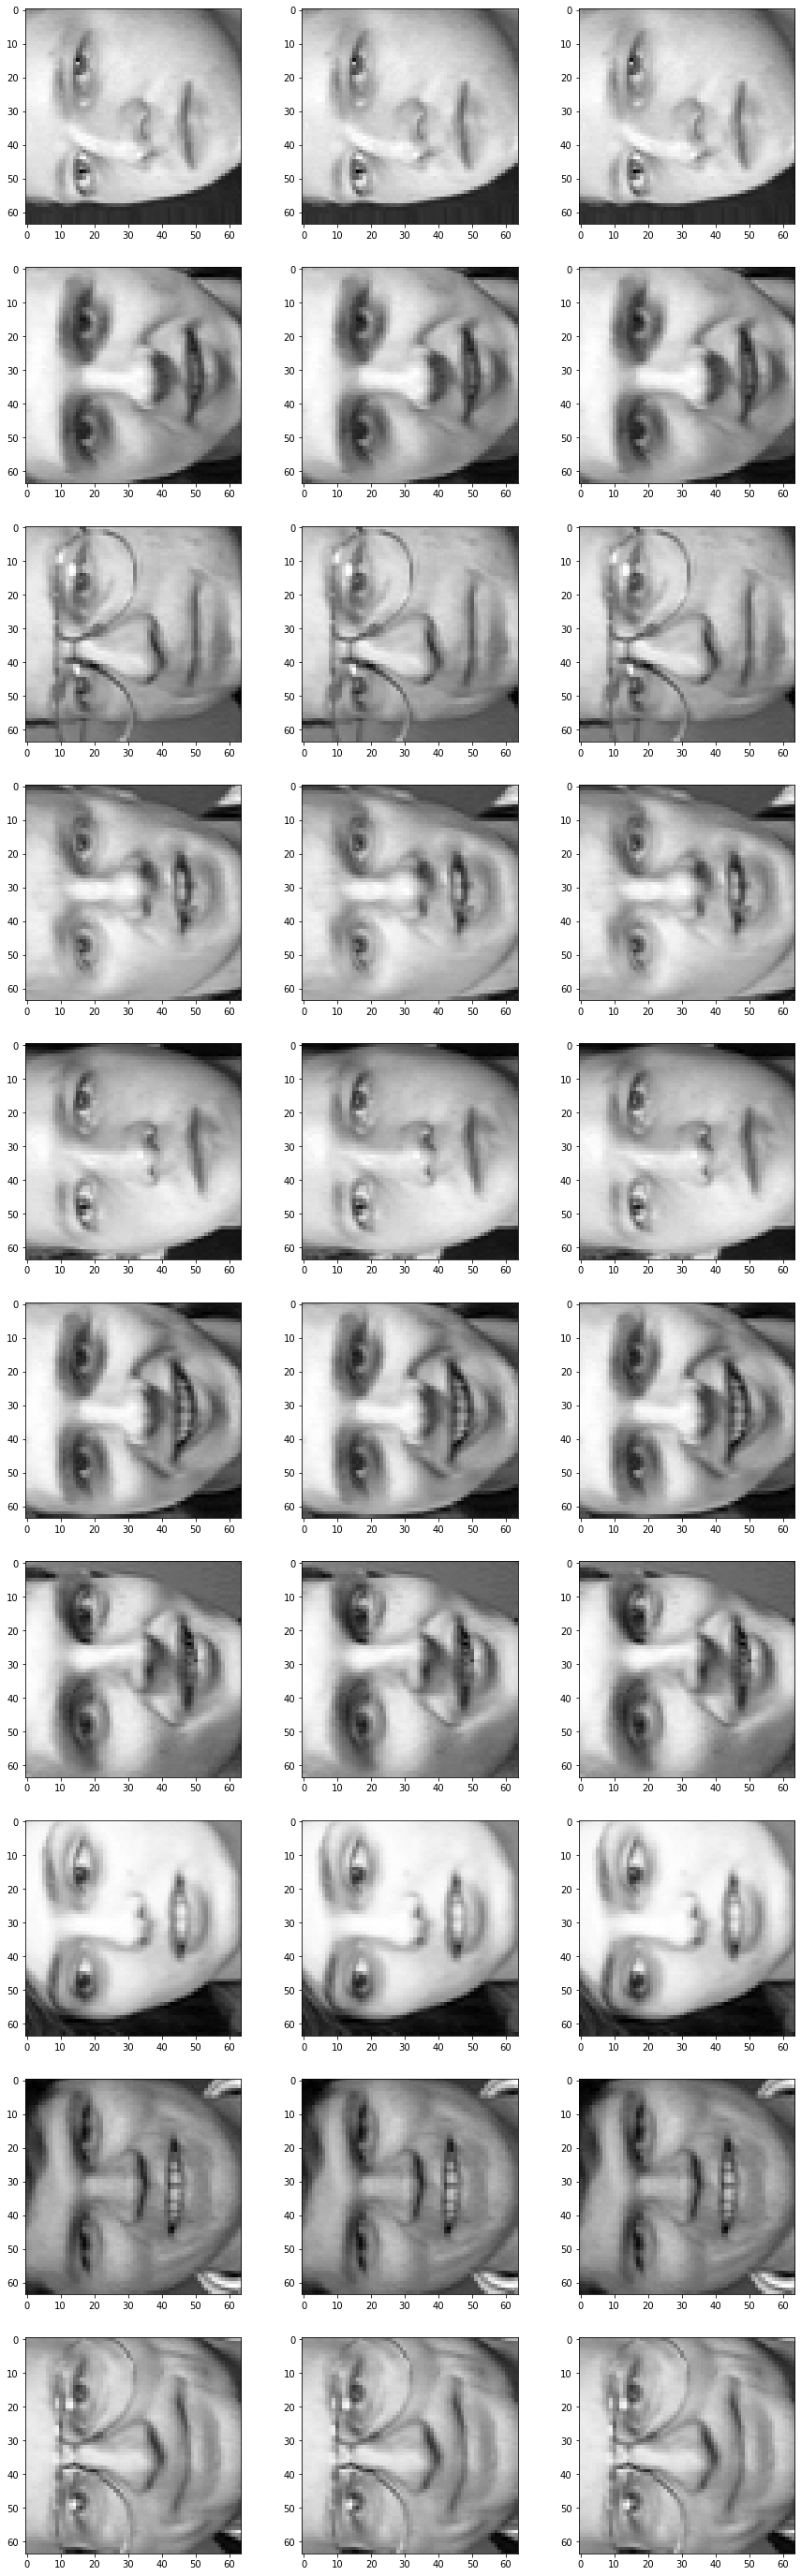

In [42]:
def g(n_components=3000):
    np.random.seed(1997)
    indices = np.random.randint(len(train_set),size=10)
    plt.figure(figsize=(15,50))
    images = train_set[indices]
    reconstructed = pca.reconstruct(pca.transform(images,n_components=n_components))
    reconstructed2 = pca.reconstruct(pca.transform(images,n_components=280))
    for i,(img,rimg,rimg2) in enumerate(zip(images,reconstructed,reconstructed2)):
        i +=1
        plt.subplot(10,3,3*i-2)
        plt.imshow(img.reshape(64,64),cmap='gray')
        plt.subplot(10,3,3*i-1)
        plt.imshow(rimg.reshape(64,64),cmap='gray')
        plt.subplot(10,3,3*i)
        plt.imshow(rimg2.reshape(64,64),cmap='gray')
        
g()
#plt.savefig('t.png')